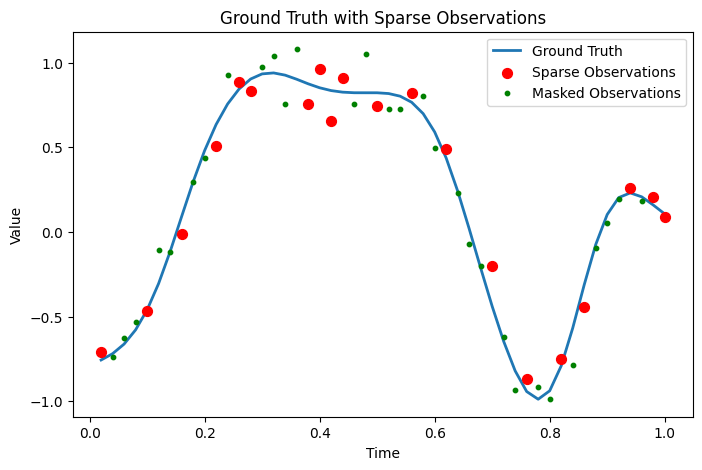

array([False,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True, False,  True, False, False])

In [1]:
import matplotlib.pyplot as plt
import dataset
import importlib
importlib.reload(dataset)
# Instantiate the synthetic dataset with 2000 trajectories.
data = dataset.SyntheticDataset(n=400, alpha=120.0, num_obs=None,noise_std=0.1, seed=42,test=True)

# Select a sample from the dataset (e.g., the first sample)
index = 1000
sample = data[index]
dense_positions = sample["positions"].numpy().squeeze(0)
ground_truth = sample["ground_truth"].numpy()
values = sample["values"].numpy()
sparse_positions = sample["sparse_positions"].numpy()
sparse_values = sample["sparse_values"].numpy()

mask = sample["mask"].numpy()

plt.figure(figsize=(8, 5))
plt.plot(dense_positions, ground_truth, label="Ground Truth", linewidth=2)  # plot dense curve
# plt.scatter(dense_positions, values, color='blue', label="Noisy realisations", s=10, zorder=5)  # scatter dense points
plt.scatter(sparse_positions, sparse_values, color='red', label="Sparse Observations", s=50, zorder=5)  # scatter sparse points
plt.scatter(dense_positions[mask], values[mask], color='green', label="Masked Observations", s=10, zorder=5)  # scatter masked points

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Ground Truth with Sparse Observations")
plt.legend()
plt.show()
mask

In [3]:
from roma.model import (RoMAForPreTraining,RoMAForPreTrainingConfig)
from roma.utils import get_encoder_size
import torch.nn as nn
import numpy as np
from Interpolation_synthetic.dataset import SyntheticDataset
from roma.utils import load_from_checkpoint
from torch.utils.data import DataLoader

test_dataset   = dataset.SyntheticDataset(n=400, alpha=120.0,noise_std=0.1, seed=42,test=True)

def evaluate_MSE():
    # Let's use the tiny model:
    encoder_args = get_encoder_size("RoMA-tiny")
    # model = load_from_checkpoint("./checkpoint-4000_orange", RoMAForPreTraining,RoMAForPreTrainingConfig)
    model = load_from_checkpoint("../checkpoint-10000_yellow", RoMAForPreTraining,RoMAForPreTrainingConfig)

    model.set_loss_fn(nn.MSELoss(reduction='mean'))
    np.random.seed(42)
    test_dataset_3  = test_dataset[:400]
    test_dataset_10 = test_dataset[400:800]
    test_dataset_20 = test_dataset[800:1200]
    
    data_to_evalutate_3  = DataLoader(test_dataset_3, batch_size=1)
    data_to_evalutate_10 = DataLoader(test_dataset_10, batch_size=1)
    data_to_evalutate_20 = DataLoader(test_dataset_20, batch_size=1)
    
    results = {3:  {"loss": 0, "predictions": []}, 
               10: {"loss": 0, "predictions": []}, 
               20: {"loss": 0, "predictions": []}}

    for key, data_to_evaluate in zip(results.keys(), [data_to_evalutate_3, data_to_evalutate_10, data_to_evalutate_20]):
        for sample in data_to_evaluate:
            prediction, ll = model(**sample)
            results[key]["loss"] += ll.item()
            results[key]["predictions"].append(prediction)

    predictions = {key: results[key]["predictions"] for key in results}
    MSE = {key: results[key]["loss"] / 400 for key in results}
    return predictions, MSE 


pred,MSEs = evaluate_MSE()




In [ ]:
import matplotlib.pyplot as plt
import dataset
from matplotlib import rc
# Instantiate the synthetic dataset with 2000 trajectories.
test_dataset_3  = test_dataset[:400]
test_dataset_10 = test_dataset[400:800]
test_dataset_20 = test_dataset[800:1200]


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)


plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('font', size=20)  # Set the font size for all text
plt.rc('axes', titlesize=20)  # Set the font size for axes titles
plt.rc('axes', labelsize=20)  # Set the font size for axes labels
plt.rc('xtick', labelsize=6)  # Set the font size for x-axis tick labels
plt.rc('ytick', labelsize=10)  # Set the font size for y-axis tick labels
plt.rc('legend', fontsize=10)  # Set the font size for legend

nnums = [3, 10, 20]
datasets = [test_dataset_3, test_dataset_10, test_dataset_20]
rc('text', usetex=True)
for ax, nnum, data in zip(axes, nnums, datasets):
    # Select a sample from the dataset (e.g., the first sample)
    index = 2
    if nnum==3:
        index = 16

    sample = data[index]
    dense_positions = sample["positions"].numpy().squeeze(0)
    ground_truth = sample["ground_truth"].numpy()
    values = sample["values"].numpy()
    sparse_positions = sample["sparse_positions"].numpy()
    sparse_values = sample["sparse_values"].numpy()
    mask = sample["mask"].numpy()
    # Predicted values from the model
    predicted_values = pred[nnum][index].detach().cpu().numpy().squeeze(0)

    ax.plot(dense_positions, ground_truth, label="Ground Truth", linewidth=2)  # plot dense curve
    ax.scatter(sparse_positions, sparse_values, color='red', label="Sparse Observations", s=50, zorder=5)  # scatter sparse points
    ax.scatter(dense_positions[mask], values[mask], color='green', label="Masked Observations", s=10, zorder=5)  # scatter masked points
    ax.plot(dense_positions[mask], predicted_values, color='orange', label="Predicted Values", linewidth=2)  # plot predicted values

    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_title(r"$n = %d$" % nnum)
    ax.legend()

plt.tight_layout()
plt.savefig("predictions_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
